In [2]:
import torch
from torch.utils.data import DataLoader
from torch.nn import Linear, Conv2d

from torchvision.models import resnet18
from torchvision.transforms import v2

from src.classifier.utils.spike_to_img import AtisImageDataset

from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt

import seaborn as sns

import pandas as pd

import numpy as np

In [4]:
N_OUT = 3

N_SUBDIV = 2

WIDTH, HEIGHT = 304, 240
WIDTH_TILE, HEIGHT_TILE = WIDTH//N_SUBDIV, HEIGHT//N_SUBDIV

transform = v2.Compose([
    v2.RandomResizedCrop((HEIGHT_TILE, WIDTH_TILE), scale=(1.0, 1.0)),
    v2.RandomHorizontalFlip(),
])

dataset_train = AtisImageDataset(f'data/box_events/{N_SUBDIV}_tiles/train_a/data_samples.npz', WIDTH_TILE, HEIGHT_TILE, transform=transform, dt_microsecs=100000.)
dataset_test = AtisImageDataset(f'data/box_events/{N_SUBDIV}_tiles/test_a/data_samples.npz', WIDTH_TILE, HEIGHT_TILE, dt_microsecs=100000.)

dataloader_train = DataLoader(dataset_train, batch_size=32, shuffle=True)
dataloader_test = DataLoader(dataset_test, batch_size=32, shuffle=True)

tensor(1)


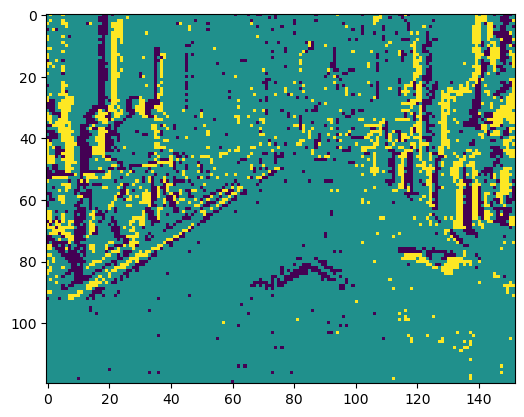

In [61]:
img, label = next(iter(dataloader_train))

plt.imshow(img[0].permute(1, 2, 0))
print(label[0])
plt.show()

In [10]:
rsn = resnet18(pretrained=False)
rsn.fc = Linear(512, N_OUT)
rsn.conv1 = Conv2d(
    1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

rsn.to(device)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [62]:
N_RUNS = 1
N_EPOCHS = 30
LEARNING_RATE = 0.0001


val_acc = np.empty((N_RUNS, N_EPOCHS))

for i, run in enumerate(range(N_RUNS)):
    rsn = resnet18(pretrained=False)
    rsn.fc = Linear(512, N_OUT)
    rsn.conv1 = Conv2d(
        1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
    )

    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(rsn.parameters(), lr=LEARNING_RATE)

    

    print(f"Run {run}")
    for j, epoch in enumerate(range(N_EPOCHS)):
        rsn.train()
        for k, (images, labels) in enumerate(dataloader_train):
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = rsn(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # if k % 100 == 0:
            #    print(f'Epoch {epoch}, step {k}, loss: {loss.item()}')

        rsn.eval()

        with torch.no_grad():
            correct = 0
            total = 0
            for images, labels in dataloader_test:
                images = images.to(device)
                labels = labels.to(device)

                outputs = rsn(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            val_acc[i, j] = correct / total

            print(f"Epoch {epoch}, accuracy: {correct / total}")

/home/fabian/miniconda3/envs/pygenn/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/fabian/miniconda3/envs/pygenn/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Run 0
Epoch 0, accuracy: 0.6246246246246246
Epoch 1, accuracy: 0.5225225225225225
Epoch 2, accuracy: 0.6316316316316316
Epoch 3, accuracy: 0.6426426426426426
Epoch 4, accuracy: 0.5585585585585585
Epoch 5, accuracy: 0.5705705705705706
Epoch 6, accuracy: 0.6196196196196196
Epoch 7, accuracy: 0.5725725725725725
Epoch 8, accuracy: 0.6266266266266266
Epoch 9, accuracy: 0.6376376376376376
Epoch 10, accuracy: 0.6356356356356356
Epoch 11, accuracy: 0.6306306306306306
Epoch 12, accuracy: 0.6266266266266266
Epoch 13, accuracy: 0.6216216216216216
Epoch 14, accuracy: 0.6236236236236237
Epoch 15, accuracy: 0.6216216216216216
Epoch 16, accuracy: 0.6086086086086087


KeyboardInterrupt: 

In [64]:
torch.save(rsn.state_dict(), "resnet18_atis.pt")

In [11]:
rsn.load_state_dict(torch.load("resnet18_atis.pt"))

<All keys matched successfully>

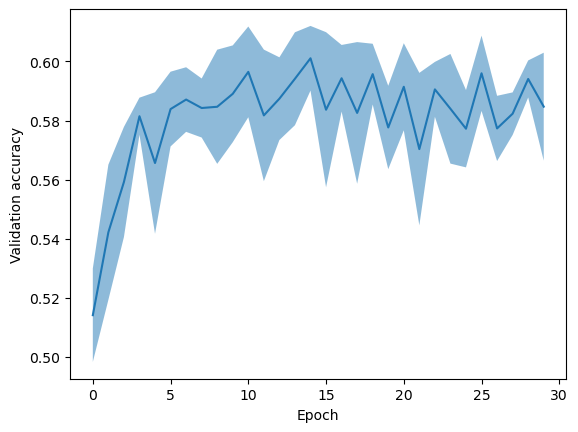

In [86]:
plt.plot(val_acc.mean(axis=0))
plt.fill_between(
    range(N_EPOCHS),
    val_acc.mean(axis=0) - val_acc.std(axis=0),
    val_acc.mean(axis=0) + val_acc.std(axis=0),
    alpha=0.5
)
plt.xlabel('Epoch')
plt.ylabel('Validation accuracy')

#plt.ylim(bottom=0.)

plt.show()

In [12]:
labels_test = np.empty(0)
preds_test = np.empty(0)

rsn.eval()
with torch.no_grad():
    for images, labels in dataloader_test:
        images = images.to(device)
        labels = labels.to(device)

        outputs = rsn(images)
        _, predicted = torch.max(outputs.data, 1)

        labels_test = np.concatenate((labels_test, labels.cpu().numpy()))
        preds_test = np.concatenate((preds_test, predicted.cpu().numpy()))


In [23]:
labels_test[:40]

array([1., 1., 2., 1., 1., 2., 2., 2., 2., 0., 2., 1., 2., 0., 1., 1., 0.,
       1., 1., 1., 1., 0., 1., 2., 2., 2., 0., 0., 2., 2., 0., 0., 2., 2.,
       2., 1., 0., 0., 0., 2.])

In [24]:
preds_test[:40]

array([1., 1., 2., 1., 1., 2., 2., 2., 2., 2., 0., 2., 2., 0., 0., 2., 1.,
       1., 2., 2., 1., 2., 0., 2., 2., 2., 0., 2., 2., 0., 1., 1., 2., 2.,
       2., 1., 2., 0., 0., 2.])

In [13]:
label_map = ['Cars', 'Pedestrians', 'None']

labels_true_test = [label_map[int(i)] for i in labels_test]
labels_pred_test = [label_map[int(i)] for i in preds_test]

df_test = pd.DataFrame({'true': labels_true_test, 'predicted': labels_pred_test})

In [28]:
labels_true_binary = np.array([int(i != 2) for i in labels_test])
labels_pred_binary = np.array([int(i != 2) for i in preds_test])

In [29]:
labels_true_binary[:4]

array([1, 1, 0, 1])

In [30]:
labels_pred_binary[:4]

array([1, 1, 0, 1])

In [31]:
print("binary accuracy:", np.mean(labels_true_binary == labels_pred_binary))

#sns.heatmap(data=df_test[(df_test["true"]!="Pedestrians") & (df_test["predicted"] != "Pedestrians")].groupby(["true", "predicted"]).size().unstack(), vmin=0)
#plt.show()

binary accuracy: 0.7187187187187187


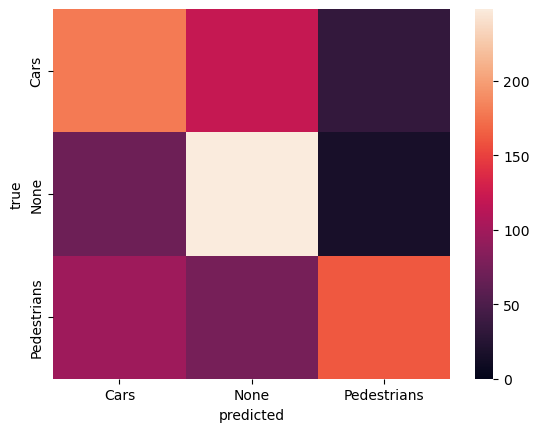

In [32]:
sns.heatmap(data=df_test.groupby(["true", "predicted"]).size().unstack(), vmin=0)
plt.show()

accuracy without pedestrians: 0.6920583468395461


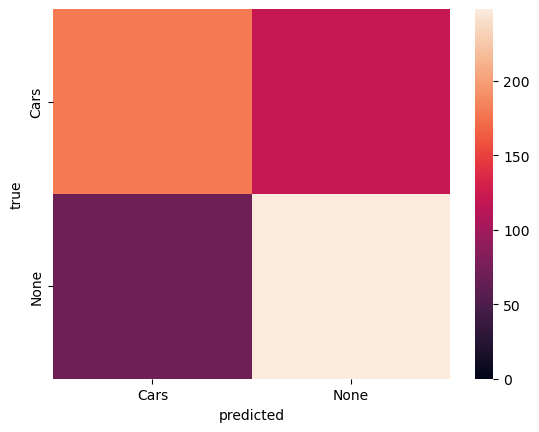

In [16]:
labels_test_without_pedestrians = labels_test[(labels_test != 1) & (preds_test != 1)]
preds_test_without_pedestrians = preds_test[(labels_test != 1) & (preds_test != 1)]

print("accuracy without pedestrians:", np.mean(labels_test_without_pedestrians == preds_test_without_pedestrians))

sns.heatmap(data=df_test[(df_test["true"]!="Pedestrians") & (df_test["predicted"] != "Pedestrians")].groupby(["true", "predicted"]).size().unstack(), vmin=0)
plt.show()

accuracy without none: 0.6994545796501787


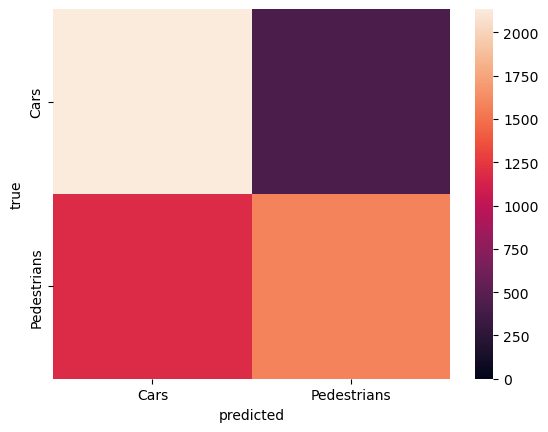

In [83]:
labels_test_without_none = labels_test[(labels_test != 2) & (preds_test != 2)]
preds_test_without_none = preds_test[(labels_test != 2) & (preds_test != 2)]

print("accuracy without none:", np.mean(labels_test_without_none == preds_test_without_none))

sns.heatmap(data=df_test[(df_test["true"]!="None") & (df_test["predicted"] != "None")].groupby(["true", "predicted"]).size().unstack(), vmin=0)
plt.show()

accuracy without cars: 0.8076165462902167


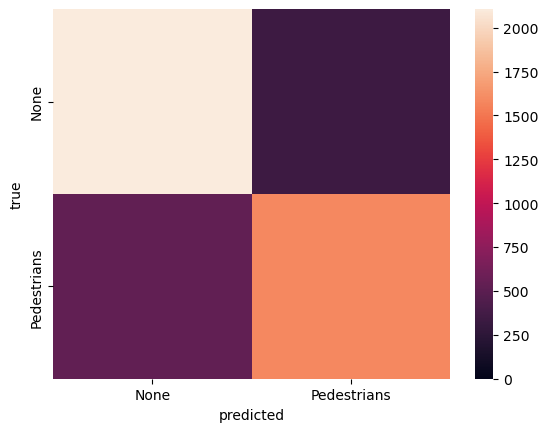

In [84]:
labels_test_without_cars = labels_test[(labels_test != 0) & (preds_test != 0)]
preds_test_without_cars = preds_test[(labels_test != 0) & (preds_test != 0)]

print("accuracy without cars:", np.mean(labels_test_without_cars == preds_test_without_cars))

sns.heatmap(data=df_test[(df_test["true"]!="Cars") & (df_test["predicted"] != "Cars")].groupby(["true", "predicted"]).size().unstack(), vmin=0)
plt.show()

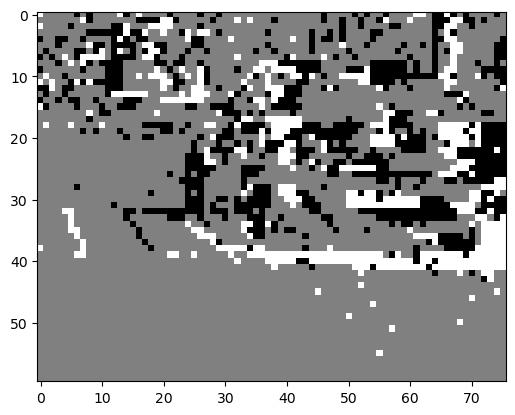

In [217]:

while True:
    idx = np.random.randint(len(dataset_test))
    img, label = dataset_test[idx]
    img = img.detach().cpu().numpy().squeeze()
    if label == 0:
        break

plt.imshow(img, cmap='gray')
plt.show()

In [13]:
import pandas as pd

plt.style.use(
    "https://raw.githubusercontent.com/FabianSchubert/mpl_style/main/custom_style.mplstyle"
)


df_no_augment = pd.read_csv("eventprop_conv_net_no_augmentation_results.txt")
df_augment = pd.read_csv("eventprop_conv_net_with_augmentation_results.txt")

df_no_augment = df_no_augment.melt(id_vars=["epoch"], value_vars=["train acc", "val acc"], var_name="type", value_name="accuracy")
df_augment = df_augment.melt(id_vars=["epoch"], value_vars=["train acc", "val acc"], var_name="type", value_name="accuracy")

/home/fabian/miniconda3/envs/pygenn/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/fabian/miniconda3/envs/pygenn/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/fabian/miniconda3/envs/pygenn/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/fabian/miniconda3/envs/pygenn/lib/python3.11/site-packages/seaborn/_oldcore.py:1075

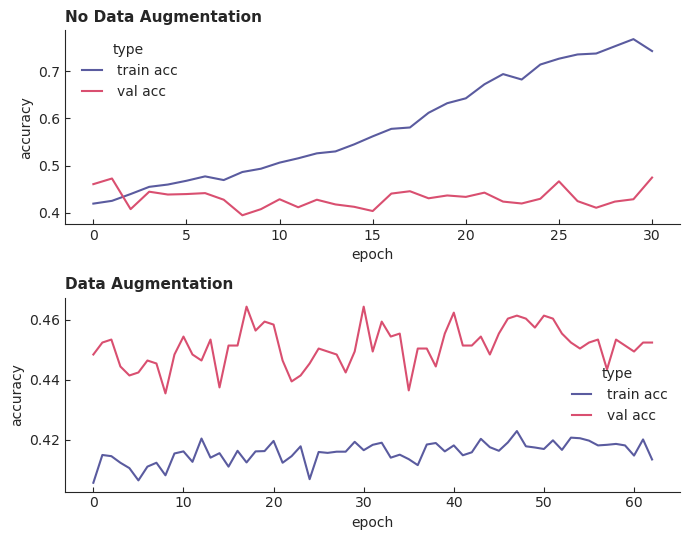

In [20]:
fig, ax = plt.subplots(2, 1, figsize=(7, 5.5))

sns.lineplot(data=df_no_augment, x="epoch", y="accuracy", hue="type", ax=ax[0])
sns.lineplot(data=df_augment, x="epoch", y="accuracy", hue="type", ax=ax[1])
ax[0].set_title("No Data Augmentation", loc="left")
ax[1].set_title("Data Augmentation", loc="left")

fig.tight_layout()
fig.savefig("cnn_spike_results.png", dpi=300)
plt.show()

/home/fabian/miniconda3/envs/pygenn/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/fabian/miniconda3/envs/pygenn/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/fabian/miniconda3/envs/pygenn/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/fabian/miniconda3/envs/pygenn/lib/python3.11/site-packages/seaborn/_oldcore.py:1075

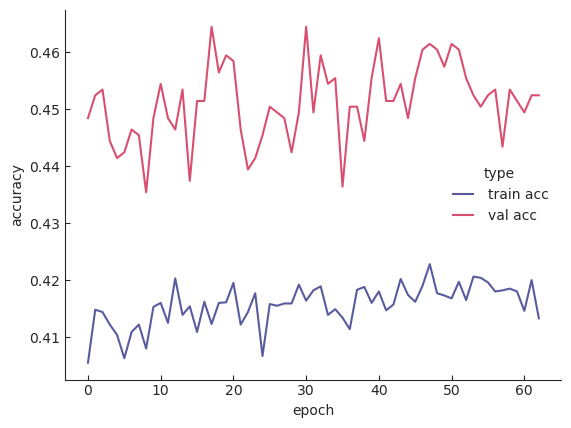

In [15]:
sns.lineplot(data=df_augment, x="epoch", y="accuracy", hue="type")
plt.show()